In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

from routing_osrm_api import TruckRouting

routing = TruckRouting()

# Test reverse geocoding
state = routing.reverse_geocode_state(40.7128, -74.0060)  # New York
print(f"State: {state}")

State: US


In [4]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

from routing_osrm_api import TruckRouting

routing = TruckRouting()

In [5]:
# Test of one trajectory
trajectory = routing.generate_trajectory("New York", "Los Angeles")
print(f"Distance: {trajectory['distance_km']:.2f} km")
print(f"Duration: {trajectory['duration_minutes']} minutes")
print(f"OSRM used: {trajectory.get('osrm_used', False)}")  

Distance: 4496.89 km
Duration: 2986 minutes
OSRM used: True


In [6]:
import time

print("Generating 100 trajectories with OSRM API...")
trajectories = []

for i in range(100):
    start, end = routing.get_random_metro_pair()
    trajectory = routing.generate_trajectory(start, end)
    trajectory['id'] = i
    trajectories.append(trajectory)
    
    if (i + 1) % 10 == 0:
        print(f"Completed: {i + 1}/100")
        time.sleep(1)  

print(f"Generated {len(trajectories)} trajectories with OSRM")

Generating 100 trajectories with OSRM API...
Completed: 10/100
Completed: 20/100
Completed: 30/100
Completed: 40/100
Completed: 50/100
Completed: 60/100
Completed: 70/100
Completed: 80/100
Completed: 90/100
Completed: 100/100
Generated 100 trajectories with OSRM


In [7]:
# Check if all trajectories use OSRM and not the fallback case
osrm_count = sum(1 for t in trajectories if t.get('osrm_used', False))
print(f"OSRM trajectories: {osrm_count}/{len(trajectories)}")

OSRM trajectories: 100/100


In [8]:
import pandas as pd

# Create summary DataFrame with OSRM data
df_summary = pd.DataFrame([{
    "id": t["id"],
    "start": t["start_metro"],
    "end": t["end_metro"],
    "distance_km": t["distance_km"],
    "duration_minutes": t["duration_minutes"],
    "avg_speed_kmh": t["avg_speed_kmh"],
} for t in trajectories])

print("OSRM DataFrame created:")
print(df_summary.head())
print(f"Total trajectories: {len(df_summary)}")

OSRM DataFrame created:
   id              start           end  distance_km  duration_minutes  \
0   0             Boston       Chicago    1596.1419              1122   
1   1  Dallas-Fort Worth  Philadelphia    2359.4011              1608   
2   2            Chicago       Houston    1725.9724              1178   
3   3       Philadelphia      New York     151.3752               121   
4   4            Chicago        Boston    1598.1536              1126   

   avg_speed_kmh  
0      77.276838  
1      91.209117  
2      77.743843  
3      81.418960  
4      90.971048  
Total trajectories: 100


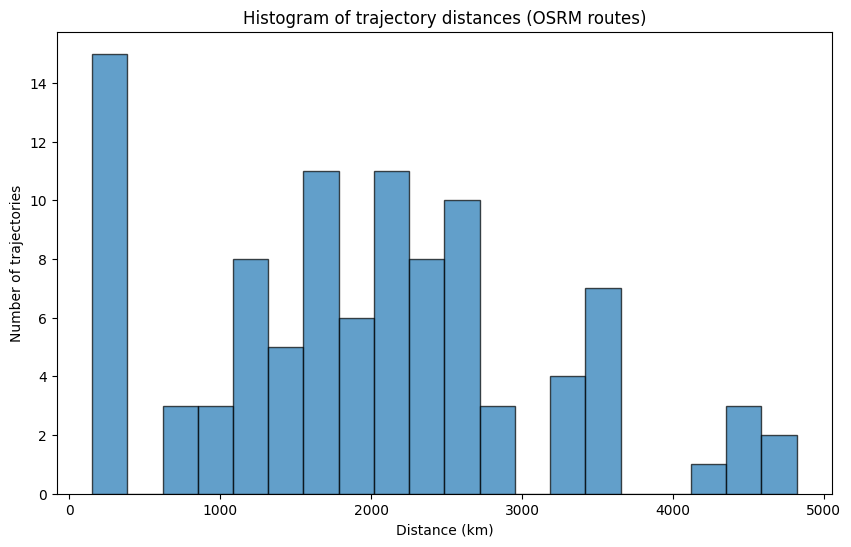

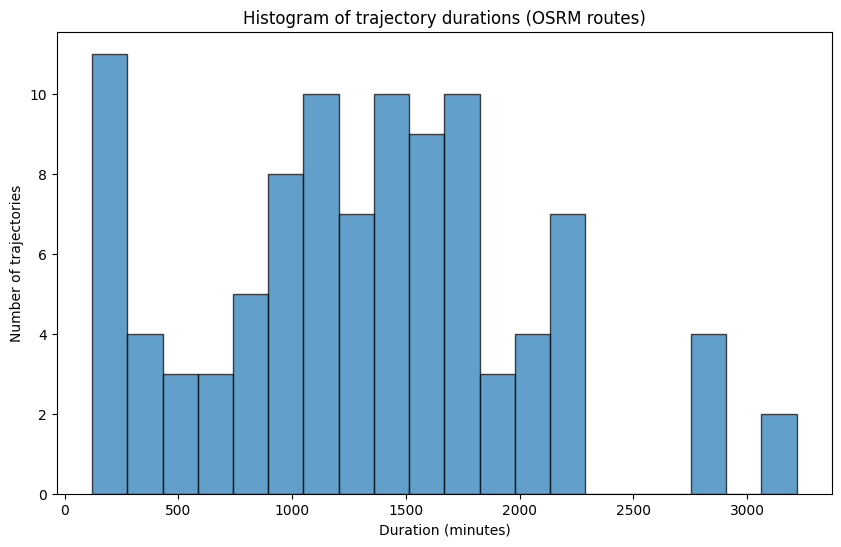

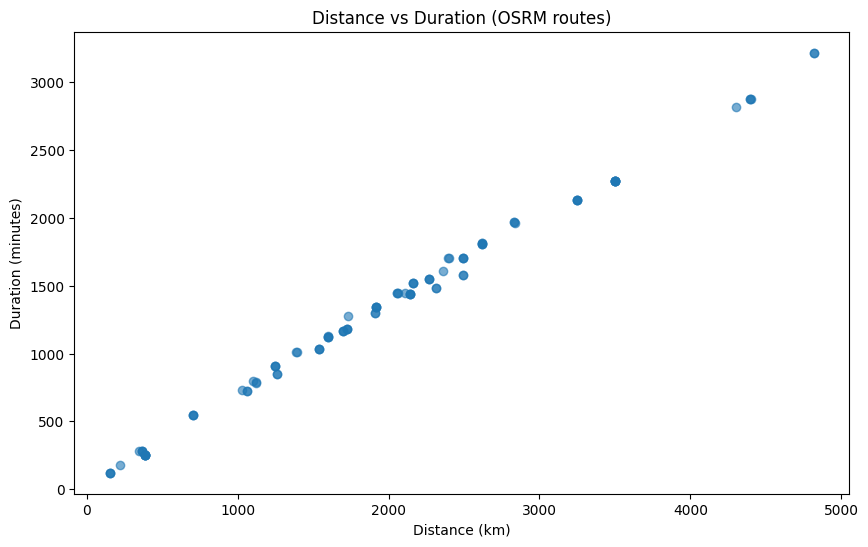

In [9]:
import matplotlib.pyplot as plt

# Histogram of distance (OSRM route)
plt.figure(figsize=(10, 6))
plt.hist(df_summary["distance_km"], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("Distance (km)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of trajectory distances (OSRM routes)")
plt.show()

# Histogram of duration (OSRM route)
plt.figure(figsize=(10, 6))
plt.hist(df_summary["duration_minutes"], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of trajectory durations (OSRM routes)")
plt.show()

# Scatter plot distance vs duration (OSRM route)
plt.figure(figsize=(10, 6))
plt.scatter(df_summary["distance_km"], df_summary["duration_minutes"], alpha=0.6)
plt.xlabel("Distance (km)")
plt.ylabel("Duration (minutes)")
plt.title("Distance vs Duration (OSRM routes)")
plt.show()

Total coordinates: 134310
Reverse geocoding progress: 10/1000
Reverse geocoding progress: 20/1000
Reverse geocoding progress: 30/1000
Reverse geocoding progress: 40/1000
Reverse geocoding progress: 50/1000
Reverse geocoding progress: 60/1000
Reverse geocoding progress: 70/1000
Reverse geocoding progress: 80/1000
Reverse geocoding progress: 90/1000
Reverse geocoding progress: 100/1000
Reverse geocoding progress: 110/1000
Reverse geocoding progress: 120/1000
Reverse geocoding progress: 130/1000
Reverse geocoding progress: 140/1000
Reverse geocoding progress: 150/1000
Reverse geocoding progress: 160/1000
Reverse geocoding progress: 170/1000
Reverse geocoding progress: 180/1000
Reverse geocoding progress: 190/1000
Reverse geocoding progress: 200/1000
Reverse geocoding progress: 210/1000
Reverse geocoding progress: 220/1000
Reverse geocoding progress: 230/1000
Reverse geocoding progress: 240/1000
Reverse geocoding progress: 250/1000
Reverse geocoding progress: 260/1000
Reverse geocoding pro

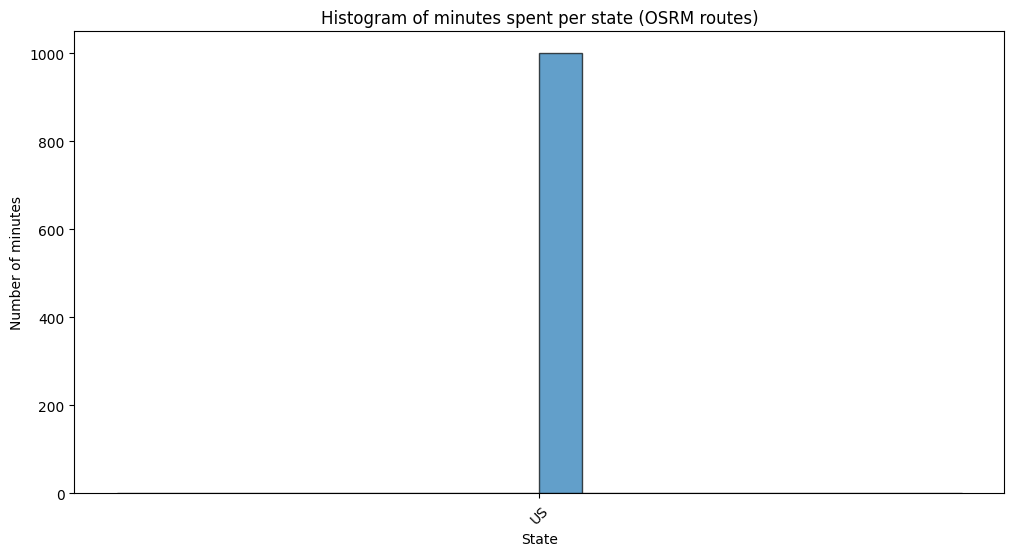

States found: {'US'}


In [10]:
# Get all coordinates
all_coords = []
for t in trajectories:
    for lat, lon in t['route_points']:
        all_coords.append((lat, lon))

print(f"Total coordinates: {len(all_coords)}")

# Reverse geocoding with OSRM
states = routing.batch_reverse_geocode(all_coords[:1000])  # Because of slowness of nominatim taking 1000 coordinates

# Histogram of minutes per state
plt.figure(figsize=(12, 6))
plt.hist(states, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("State")
plt.ylabel("Number of minutes")
plt.title("Histogram of minutes spent per state (OSRM routes)")
plt.xticks(rotation=45)
plt.show()

print(f"States found: {set(states)}")

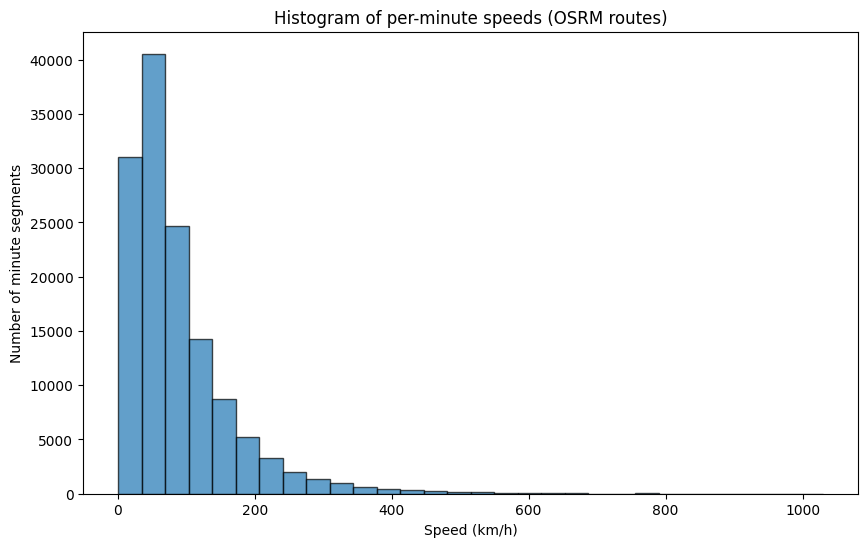

Total speed measurements: 134210
Average speed: 88.00 km/h


In [11]:
# Calculate per-minute speeds
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# Calculate speeds for each trajectory
speeds = []
for t in trajectories:
    route_points = t['route_points']
    for i in range(1, len(route_points)):
        d_km = haversine(route_points[i-1][0], route_points[i-1][1], 
                        route_points[i][0], route_points[i][1])
        speed_kmh = d_km * 60  # 1 minute = 60 times speed in km/h
        speeds.append(speed_kmh)

# Histogram of per-minute speeds
plt.figure(figsize=(10, 6))
plt.hist(speeds, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel("Speed (km/h)")
plt.ylabel("Number of minute segments")
plt.title("Histogram of per-minute speeds (OSRM routes)")
plt.show()

print(f"Total speed measurements: {len(speeds)}")
print(f"Average speed: {sum(speeds)/len(speeds):.2f} km/h")

In [18]:
import os

# Create trajectories directory
os.makedirs('../data/trajectories', exist_ok=True)

# Save summary DataFrame
df_summary.to_csv('../data/trajectories/trajectory_summary.csv', index=False)
print("Saved trajectory summary to ../data/trajectories/")

# Save states
df_states = pd.DataFrame({'state': states})
df_states.to_csv('../data/trajectories/state_minutes.csv', index=False)
print("Saved state minutes to ../data/trajectories/")

# Save speeds
df_speeds = pd.DataFrame({'speed_kmh': speeds})
df_speeds.to_csv('../data/trajectories/per_minute_speeds.csv', index=False)
print("Saved per-minute speeds to ../data/trajectories/")

Saved trajectory summary to ../data/trajectories/
Saved state minutes to ../data/trajectories/
Saved per-minute speeds to ../data/trajectories/


=== DISTANCE STATISTICS ===
count     100.000000
mean     1975.764045
std      1122.359544
min       151.375200
25%      1245.938700
50%      1914.785500
75%      2526.589800
max      4820.803400
Name: distance_km, dtype: float64
Min distance: 151.4 km
Max distance: 4820.8 km
Mean distance: 1975.8 km

=== DURATION STATISTICS ===
count     100.000000
mean     1342.100000
std       730.521946
min       121.000000
25%       848.000000
50%      1343.000000
75%      1733.750000
max      3218.000000
Name: duration_minutes, dtype: float64
Min duration: 121.0 minutes (2.0 hours)
Max duration: 3218.0 minutes (53.6 hours)
Mean duration: 1342.1 minutes (22.4 hours)

=== SPEED STATISTICS ===
count    100.000000
mean      82.398821
std        7.003688
min       70.044606
25%       76.117469
50%       82.042797
75%       88.762036
max       94.769362
Name: avg_speed_kmh, dtype: float64
Min speed: 70.0 km/h
Max speed: 94.8 km/h
Mean speed: 82.4 km/h

=== CORRELATION ===
Distance-Duration correlation:

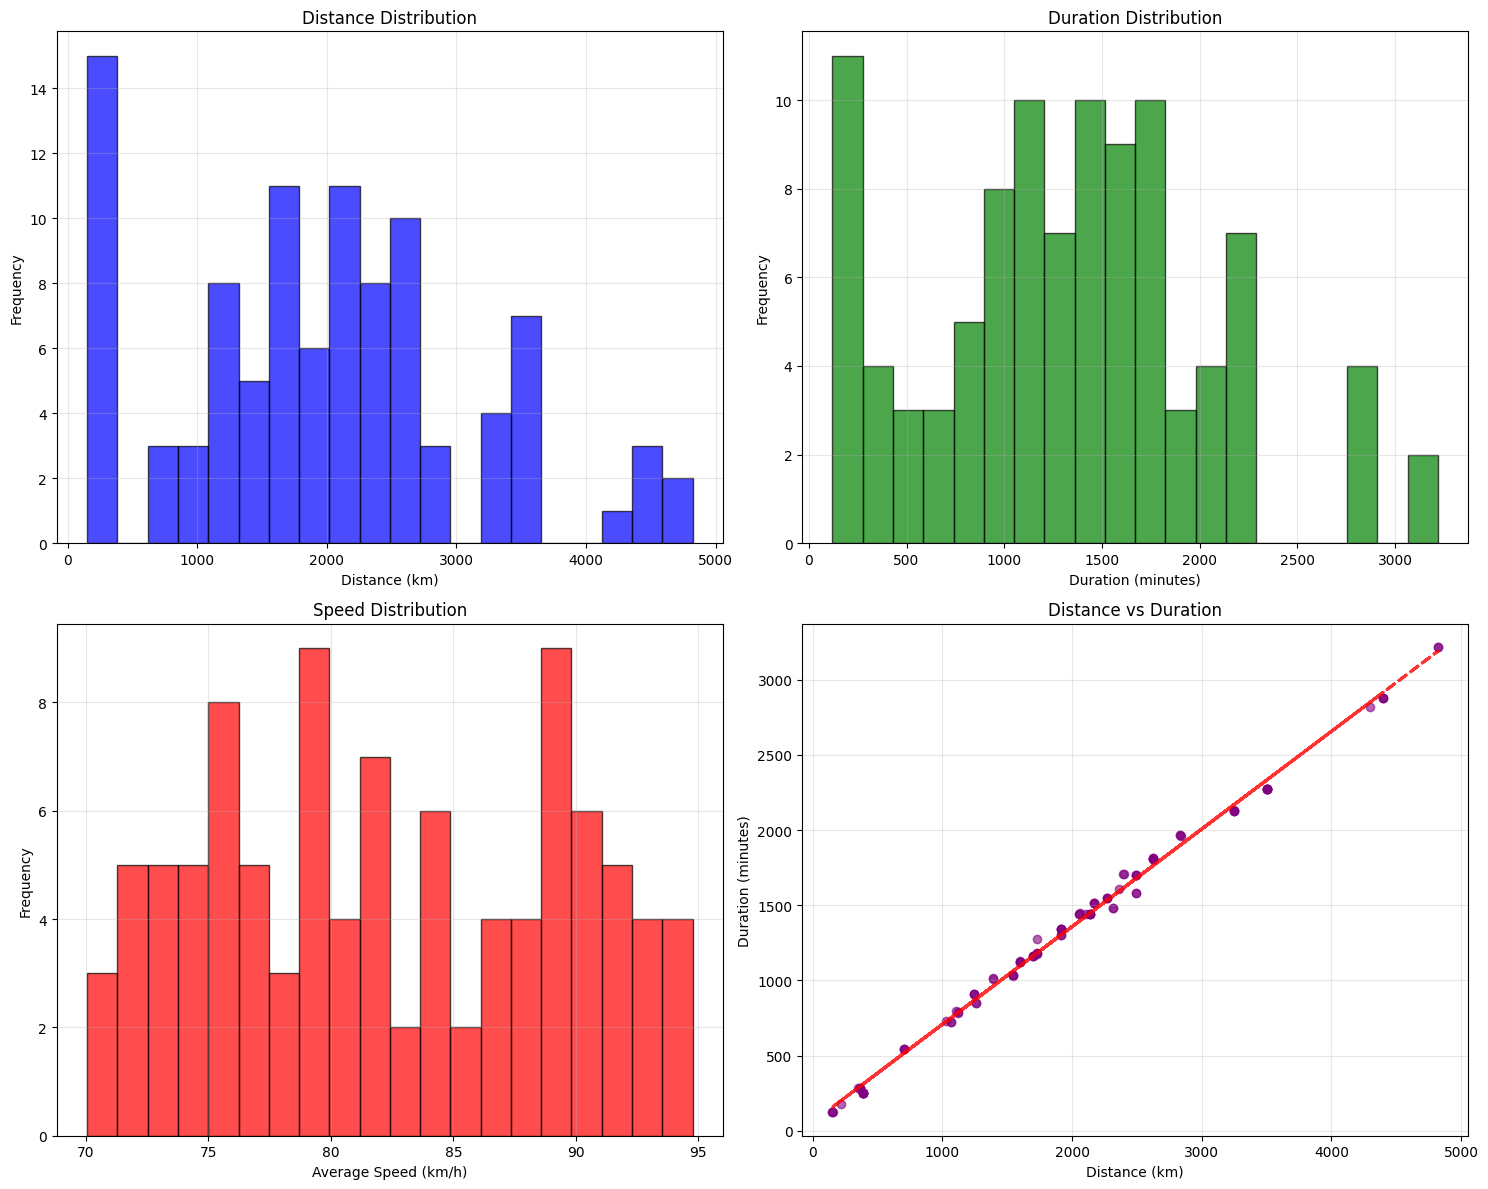


=== FINAL ASSESSMENT ===
All routes have realistic parameters!
Strong correlation between distance and duration - realistic!

Overall data quality: GOOD


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data
df = pd.read_csv('../data/trajectories/trajectory_summary.csv')

# Check basic statistics
print("=== DISTANCE STATISTICS ===")
print(df['distance_km'].describe())
print(f"Min distance: {df['distance_km'].min():.1f} km")
print(f"Max distance: {df['distance_km'].max():.1f} km")
print(f"Mean distance: {df['distance_km'].mean():.1f} km")

print("\n=== DURATION STATISTICS ===")
print(df['duration_minutes'].describe())
print(f"Min duration: {df['duration_minutes'].min():.1f} minutes ({df['duration_minutes'].min()/60:.1f} hours)")
print(f"Max duration: {df['duration_minutes'].max():.1f} minutes ({df['duration_minutes'].max()/60:.1f} hours)")
print(f"Mean duration: {df['duration_minutes'].mean():.1f} minutes ({df['duration_minutes'].mean()/60:.1f} hours)")

print("\n=== SPEED STATISTICS ===")
print(df['avg_speed_kmh'].describe())
print(f"Min speed: {df['avg_speed_kmh'].min():.1f} km/h")
print(f"Max speed: {df['avg_speed_kmh'].max():.1f} km/h")
print(f"Mean speed: {df['avg_speed_kmh'].mean():.1f} km/h")

# Check correlation
correlation = df['distance_km'].corr(df['duration_minutes'])
print(f"\n=== CORRELATION ===")
print(f"Distance-Duration correlation: {correlation:.3f}")

# Quality checks
print(f"\n=== QUALITY CHECKS ===")

# Check for unrealistic speeds
unrealistic_speeds = df[(df['avg_speed_kmh'] < 50) | (df['avg_speed_kmh'] > 120)]
print(f"Unrealistic speeds (<50 or >120 km/h): {len(unrealistic_speeds)} routes")

# Check for unrealistic distances
unrealistic_distances = df[(df['distance_km'] < 50) | (df['distance_km'] > 5000)]
print(f"Unrealistic distances (<50 or >5000 km): {len(unrealistic_distances)} routes")

# Check for unrealistic durations
unrealistic_durations = df[(df['duration_minutes'] < 60) | (df['duration_minutes'] > 5000)]
print(f"Unrealistic durations (<1h or >83h): {len(unrealistic_durations)} routes")

# Check speed consistency
speed_consistency = df['distance_km'] / (df['duration_minutes'] / 60)
speed_diff = abs(speed_consistency - df['avg_speed_kmh'])
print(f"Speed consistency check - max difference: {speed_diff.max():.2f} km/h")

print(f"\n=== ROUTE EXAMPLES ===")
print("Shortest route:")
shortest = df.loc[df['distance_km'].idxmin()]
print(f"  {shortest['start']} → {shortest['end']}: {shortest['distance_km']:.1f} km, {shortest['duration_minutes']:.0f} min, {shortest['avg_speed_kmh']:.1f} km/h")

print("\nLongest route:")
longest = df.loc[df['distance_km'].idxmax()]
print(f"  {longest['start']} → {longest['end']}: {longest['distance_km']:.1f} km, {longest['duration_minutes']:.0f} min, {longest['avg_speed_kmh']:.1f} km/h")

print("\nFastest route:")
fastest = df.loc[df['avg_speed_kmh'].idxmax()]
print(f"  {fastest['start']} → {fastest['end']}: {fastest['distance_km']:.1f} km, {fastest['duration_minutes']:.0f} min, {fastest['avg_speed_kmh']:.1f} km/h")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distance histogram
axes[0, 0].hist(df['distance_km'], bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Distance Distribution')
axes[0, 0].set_xlabel('Distance (km)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Duration histogram
axes[0, 1].hist(df['duration_minutes'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Duration Distribution')
axes[0, 1].set_xlabel('Duration (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Speed histogram
axes[1, 0].hist(df['avg_speed_kmh'], bins=20, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title('Speed Distribution')
axes[1, 0].set_xlabel('Average Speed (km/h)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Distance vs Duration scatter plot
axes[1, 1].scatter(df['distance_km'], df['duration_minutes'], alpha=0.6, color='purple')
axes[1, 1].set_title('Distance vs Duration')
axes[1, 1].set_xlabel('Distance (km)')
axes[1, 1].set_ylabel('Duration (minutes)')
axes[1, 1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df['distance_km'], df['duration_minutes'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df['distance_km'], p(df['distance_km']), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Final assessment
print(f"\n=== FINAL ASSESSMENT ===")
if len(unrealistic_speeds) == 0 and len(unrealistic_distances) == 0 and len(unrealistic_durations) == 0:
    print("All routes have realistic parameters!")
else:
    print("Some routes have unrealistic parameters - check the data!")

if correlation > 0.8:
    print("Strong correlation between distance and duration - realistic!")
else:
    print("Weak correlation - might indicate data issues!")

print(f"\nOverall data quality: {'GOOD' if len(unrealistic_speeds) == 0 and correlation > 0.8 else 'NEEDS REVIEW'}")

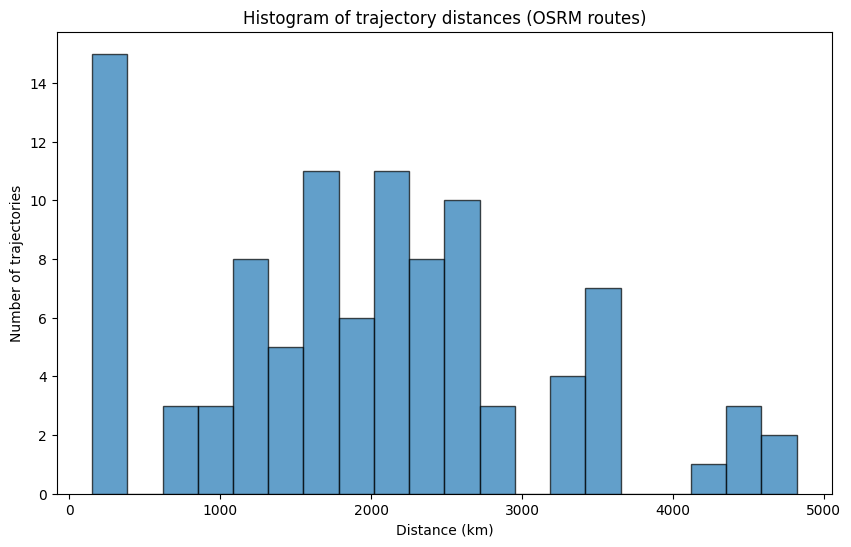

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(df_summary["distance_km"], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("Distance (km)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of trajectory distances (OSRM routes)")
plt.savefig('../data/plots/distance_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

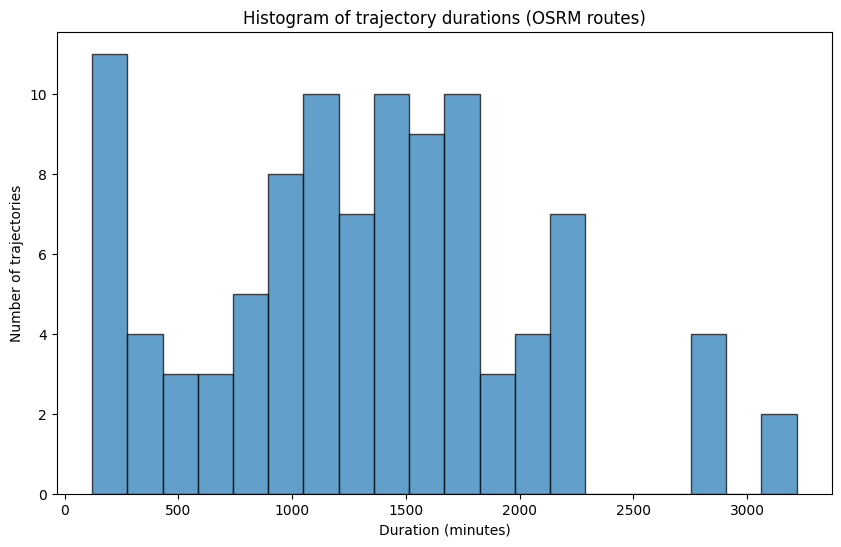

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df_summary["duration_minutes"], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of trajectory durations (OSRM routes)")
plt.savefig('../data/plots/duration_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

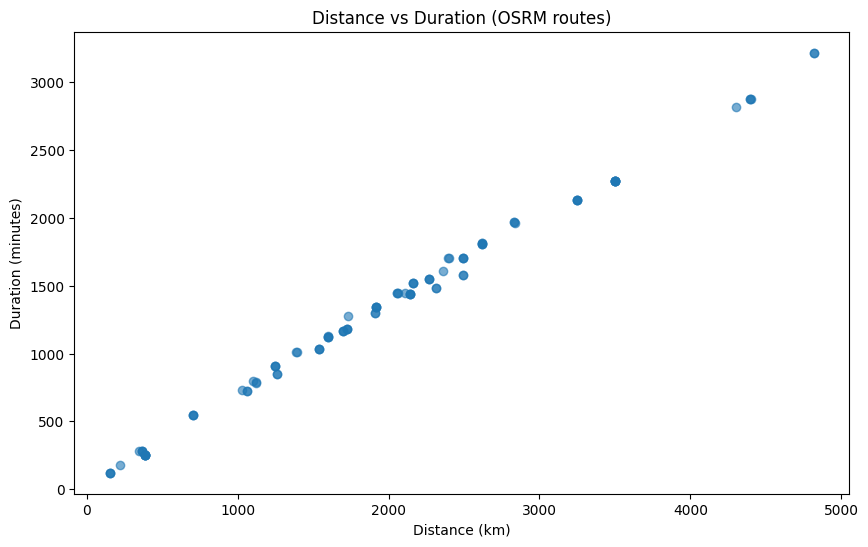

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(df_summary["distance_km"], df_summary["duration_minutes"], alpha=0.6)
plt.xlabel("Distance (km)")
plt.ylabel("Duration (minutes)")
plt.title("Distance vs Duration (OSRM routes)")
plt.savefig('../data/plots/distance_vs_duration.png', dpi=300, bbox_inches='tight')
plt.show()

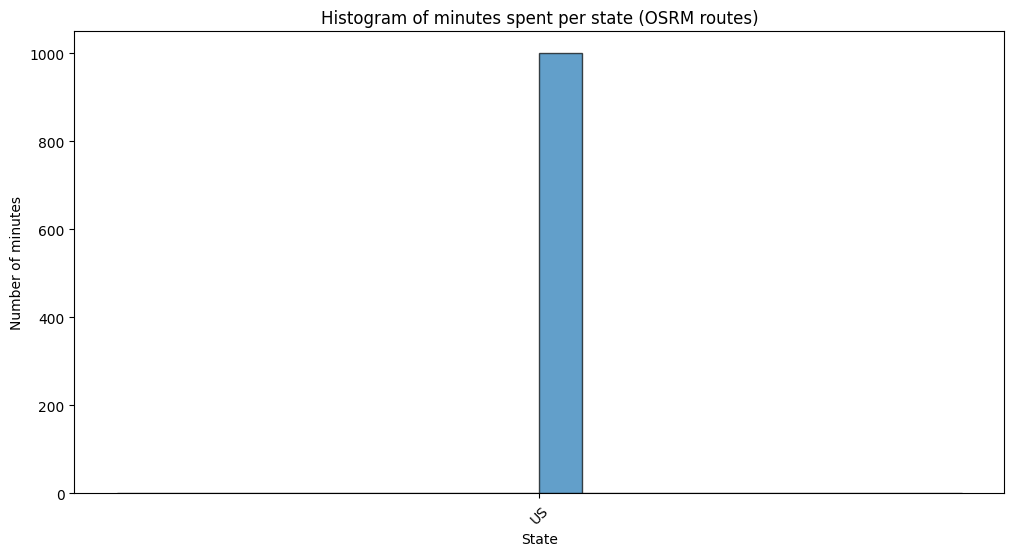

In [24]:
plt.figure(figsize=(12, 6))
plt.hist(states, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("State")
plt.ylabel("Number of minutes")
plt.title("Histogram of minutes spent per state (OSRM routes)")
plt.xticks(rotation=45)
plt.savefig('../data/plots/state_minutes_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

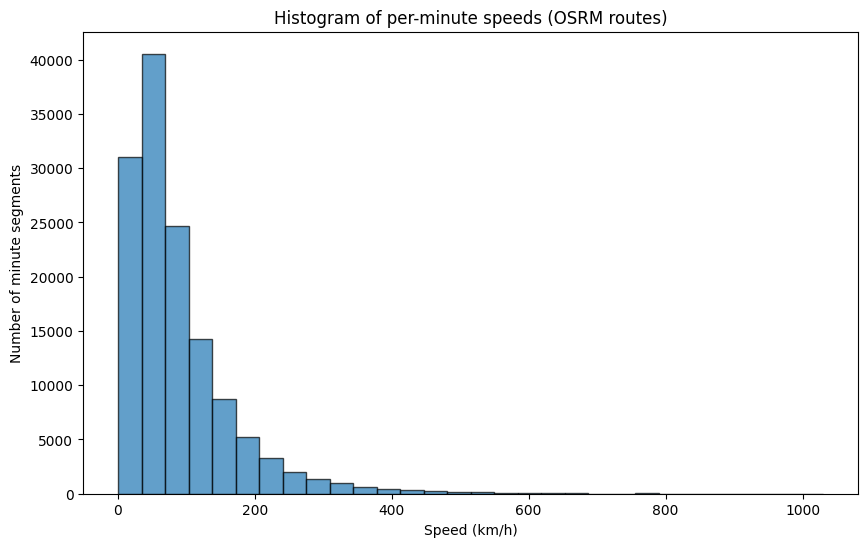

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(speeds, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel("Speed (km/h)")
plt.ylabel("Number of minute segments")
plt.title("Histogram of per-minute speeds (OSRM routes)")
plt.savefig('../data/plots/speed_histogram.png', dpi=300, bbox_inches='tight')
plt.show()